# Introduction

We are the Neighborhood Navigators and we have come with an answer to the long asked question of "What is the best neighborhood in Pittsburgh?". As with any good city, we feel as though the best neighborhoods are the ones that are the easiest to commit arson in. 

### The Metric

In order to figure out which neighborhood would be ideal for someone to commit arson, we first had to figure out what would be ideal in an area for arson to take place in. Based off our discussions we decided that the neighborhood with the highest amount of vacant buildings, most amount of fires, and least amount of arrests would be the best place in Pittsburgh to commit arson. These areas would be the ones where fire wouldn't be out of the ordinary in the environment which would keep attention on the arson minimal, and would contain a lot of spaces to set something on fire without potential legal repurcussion.

In order to find out our metric we used the following datasets from the WPRDC.

[**Fire Incidents in City of Pittsburgh**](https://data.wprdc.org/dataset/fire-incidents-in-city-of-pittsburgh)

[**Pittsburgh Police Arrest Data**](https://data.wprdc.org/dataset/arrest-data)

[**Pennsylvania Vacant Addresses**](https://data.wprdc.org/dataset/vacant-addresses)

[**Population by Municipality**](https://data.wprdc.org/dataset/2020-census-redistricting-data-extracts/resource/fb2cb765-458c-4deb-8252-0a18d7ce9a78)


#### Fire Incidents

Finding the area in Pittsburgh with the most amount of fires would mean that the area would be more susceptible to fires in the future and it would be fairly common for fires to take place in the area, which we would want if we we're looking to commit arson and not stand out.

The dataset has all of these fires listed and categorized by things such as the type and building but I decided to group it based off the neighborhood each fire occured in.

In [2]:
import pandas as pd
import geopandas
%matplotlib inline

incidents = pd.read_csv("fire_incidents.csv")

incidents_by_neighborhood = incidents.groupby('neighborhood').size().reset_index(name='incident_type')
sorted_incidents = incidents_by_neighborhood.sort_values(by='incident_type', ascending=False)
pd.set_option('display.max_rows', None)

print(sorted_incidents)

                 neighborhood  incident_type
15                    Carrick            280
16  Central Business District            255
72           South Side Flats            251
77        Squirrel Hill South            247
38                  Hazelwood            238
53           Mount Washington            208
28               East Liberty            198
46   Lincoln-Lemington-Belmar            188
41             Homewood South            185
13                  Brookline            181
40             Homewood North            176
68                  Shadyside            168
9                  Bloomfield            166
43                  Knoxville            164
69                   Sheraden            162
62                Perry South            155
27                 East Hills            152
12           Brighton Heights            144
7                   Beechview            142
10                      Bluff            135
49         Marshall-Shadeland            133
8         

From this data we see that places Carrick, Central Business District, South Side Flats, Squirrel Hill South, and Hazelwood had the most amount of fires reported while Mount Oliver, Regent Square, East Carneige, and St. Clair had the least.

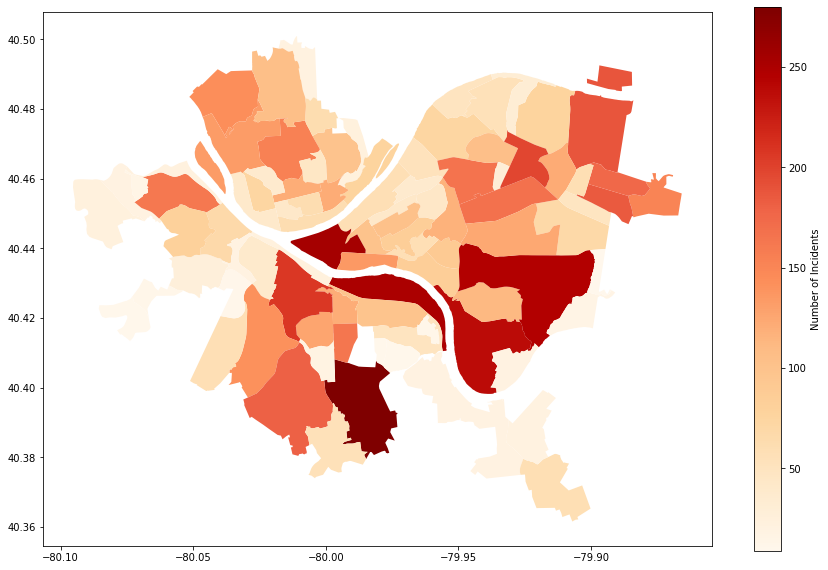

In [3]:
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")
# plot test done to see if shapefile was read correctly
#neighborhoods.plot() 


incidents_map = neighborhoods.merge(incidents_by_neighborhood, how='left', left_on='hood', right_on='neighborhood')
incidents_map[['hood','incident_type','geometry']].head()
incidents_map.plot(column='incident_type',cmap='OrRd', legend=True, legend_kwds={'label': "Number of Incidents"}, figsize=(15, 10))

And this is what the data looks like when mapped on the neighborhoods of Pittsburgh. As the map shows, Carrick and Mount Washington (which are right next to each) has the highest density of reported fires but areas such as the Central Business District of downtown and South Side Flats also have a high amount. Personally my favorite neighborhoods are the ones that Pitt's campus resides on (so South and Central Oakland) and those are fairly far down on the list so they aren't an ideal place for us to commit arson in.

#### Arrests

![pic 1](arrest_1.png)
![pic 2](arrest_2.png)
![pic 3](arrest_3.png)
![pic 4](arrest_4.png)
![pic 5](arrest_5_map.png)
![pic 6](arrest_6.png)

#### Vacancies
![pic 1](pic_1.png)
![pic 2](pic_2.png)
![pic 3](pic_3.png)
![pic 4](pic_4.png)
![pic 5](pic_5.png)
![pic 6](pic_6.png)

### The Best Neighborhood
##### Conclusion

Based off of our analysis, we determined that the best neighborhood to commit arson in is Mount Washington. After looking at the lists of data and creating a spreadsheet based off of the list of rankings for each of the 3 categories, Mount Washington came out as the one on top. Mount Washington had the 6th highest amount of fire incidents, the 43rd highest in fewest arrests, and the 3rd most vacant neighborhood in Pittsburgh. Compared to the averages from the other areas it was clear that Mount Washington is the best neighborhood to commit arson in.